<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/ReviewTokoBaju_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt


In [25]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [26]:
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)


In [27]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [28]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [31]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# ==== Hyperparameter ====
epochs = 10
num_words = 15000
maxlen = 200
batch_size = 256
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.15


# ==== Tentukan kolom yang digunakan ====
review_col = 'Review Text'
rating_col = 'Rating'

# ==== Cek dan isi NaN ====
df[review_col] = df[review_col].fillna("").astype(str)

# ==== Preprocessing Teks ====
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)     # Hapus tanda baca
        text = re.sub(r'\d+', '', text)         # Hapus angka
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        return ' '.join([w for w in words if w not in stop_words])
    else:
        return ""

df['processed_review'] = df[review_col].apply(preprocess_text)

# ==== Labeling ====
rating_threshold = 3
df['sentiment'] = (df[rating_col] > rating_threshold).astype(int)

# ==== Buat Vocabulary ====
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common(max_words - 1))}
    vocab['<PAD>'] = 0
    return vocab

vocabulary = build_vocab(df['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

# ==== Convert teks ke sequence ====
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # 0 untuk OOV dan padding
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    else:
        return sequence + [0] * (maxlen - len(sequence))

df['sequence'] = df['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

# ==== Split Dataset ====
X = np.array(df['sequence'].tolist())
y = np.array(df['sentiment'].tolist())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Vocabulary size: 15000
Train size: (18788, 200), Test size: (4698, 200)


#Model RNN

In [32]:
def build_rnn_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))

    # Hidden RNN Layers
    for i in range(num_layers - 1):
        model.add(SimpleRNN(hidden_dim,
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))

    # Last RNN Layer
    model.add(SimpleRNN(hidden_dim,
                        return_sequences=True,
                        dropout=dropout,
                        kernel_initializer='orthogonal',
                        recurrent_initializer='orthogonal',
                        bias_initializer='zeros'))

    # Global Max Pooling
    model.add(GlobalMaxPooling1D())

    # Dense + Dropout
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout))

    # Output Layer
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros'))

    return model

# ==== Create and Compile Model ====
model = build_rnn_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==== Callbacks ====
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.7127 - loss: 0.5726 - val_accuracy: 0.7997 - val_loss: 0.4391 - learning_rate: 1.0000e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.8159 - loss: 0.4109 - val_accuracy: 0.8555 - val_loss: 0.3398 - learning_rate: 1.0000e-04
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8721 - loss: 0.3093 - val_accuracy: 0.8650 - val_loss: 0.3150 - learning_rate: 1.0000e-04
Epoch 4/10
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8914 - loss: 0.2679
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8914 - loss: 0.2677 - val_accuracy: 0.8674 - val_loss: 0.3182 - learning_rate: 1.0000e-04
Epoch 5/10
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9060 - loss: 0.2371
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9061 - loss

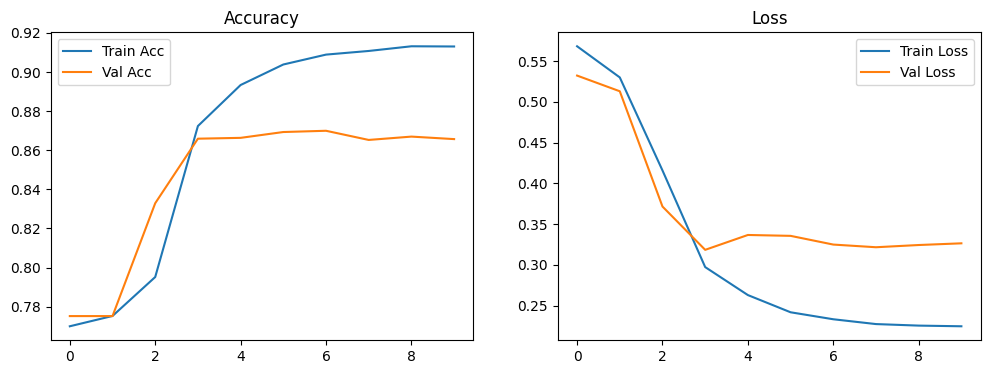

147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Final Evaluation on Test Set:
Accuracy : 0.8644
Precision: 0.9062
Recall   : 0.9204
F1 Score : 0.9132
AUC      : 0.9054
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1056
           1       0.91      0.92      0.91      3642

    accuracy                           0.86      4698
   macro avg       0.81      0.80      0.80      4698
weighted avg       0.86      0.86      0.86      4698

AUC Score: 0.7958874681743298


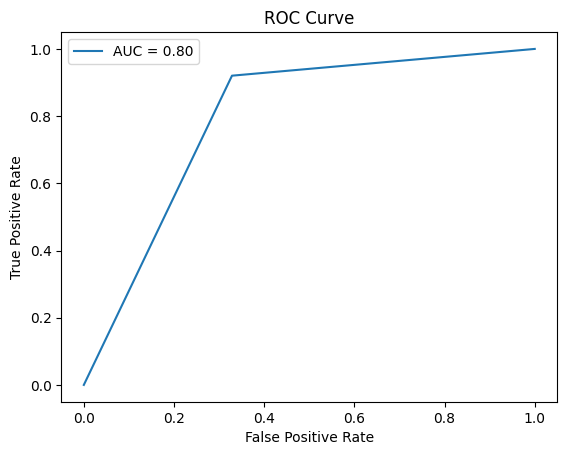


Information:
 1 : Recommended
 0 : Not Recommended

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Sample Predictions:
1. Text: dress horrible cant believe get away calling dress called tunic shirt looks like soft flowing dress ...
   True: 0, Pred: 0, Prob: 0.1731

2. Text: bought dress half sale price practically steal must say absolutely adore runs pretty tts available o...
   True: 1, Pred: 1, Prob: 0.9984

3. Text: ordered top white cream color combo love much buttons back add sweet touch easy top fall spring easy...
   True: 1, Pred: 1, Prob: 0.9972

4. Text: super flattering stretch little repeated wear much pairs love
   True: 1, Pred: 1, Prob: 0.96

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluation Metrics
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


print(classification_report(y_test, y_pred_bin))
print("AUC Score:", roc_auc_score(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred):.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


def get_sample_predictions(n_samples=10):
    samples = []

    # Create reverse vocabulary for visualization
    idx_to_word = {idx: word for word, idx in vocabulary.items()}

    # Get some random samples from test set
    indices = np.random.choice(len(X_test), n_samples, replace=False)

    for i in indices:
        # Get sequence and convert to text
        seq = X_test[i]
        words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
        text = ' '.join(words)

        # Get true and predicted values
        true_val = y_test[i]
        prob_val = model.predict(np.expand_dims(seq, axis=0))[0][0]
        pred_val = 1 if prob_val >= 0.5 else 0

        samples.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true': true_val,
            'pred': pred_val,
            'prob': prob_val
        })

    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions()
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

#LSTM Model

In [41]:
def build_lstm_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
    model = Sequential()

    # Add embedding layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))

    # Add LSTM layers
    for i in range(num_layers - 1):
        model.add(LSTM(hidden_dim,
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))

    # Last LSTM layer with return_sequences=False to get only the last output
    model.add(LSTM(hidden_dim,
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))

    # Global Max Pooling to get the most important features
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation="relu"))

    # Dropout before final layer
    model.add(Dropout(dropout))

    # Final dense layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid',
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))

    return model

# Create the model
model = build_lstm_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.7532 - loss: 0.6112 - val_accuracy: 0.7752 - val_loss: 0.5323 - learning_rate: 1.0000e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.7784 - loss: 0.5288 - val_accuracy: 0.7752 - val_loss: 0.5131 - learning_rate: 1.0000e-04
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.7834 - loss: 0.4548 - val_accuracy: 0.8329 - val_loss: 0.3717 - learning_rate: 1.0000e-04
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.8615 - loss: 0.3148 - val_accuracy: 0.8659 - val_loss: 0.3185 - learning_rate: 1.0000e-04
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8917 - loss: 0.2670
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.8917 - loss: 0.2670 - val_accuracy: 0.8663 - val_loss: 0.3368 - learning_rate: 1.0000e-04
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 

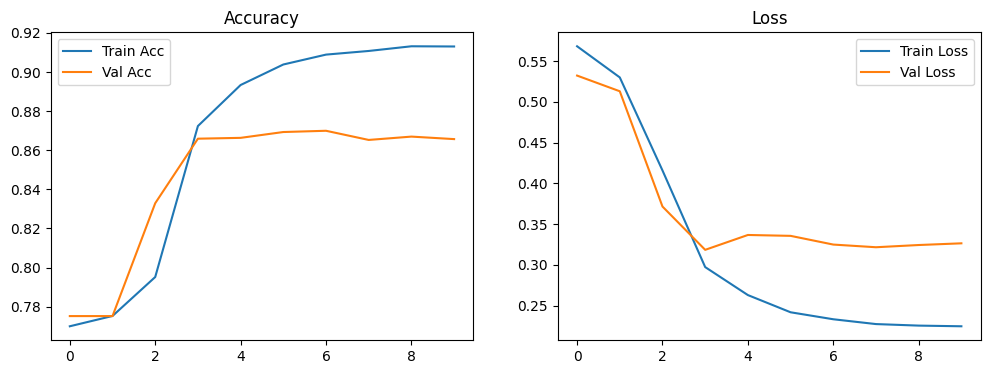

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Final Evaluation on Test Set:
Accuracy : 0.8629
Precision: 0.9065
Recall   : 0.9179
F1 Score : 0.9121
AUC      : 0.9078
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1056
           1       0.91      0.92      0.91      3642

    accuracy                           0.87      4698
   macro avg       0.81      0.80      0.80      4698
weighted avg       0.86      0.87      0.86      4698

AUC Score: 0.795598853027807


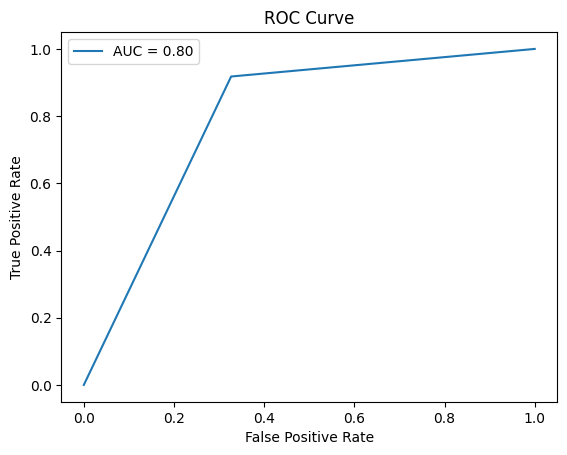


Information:
 1 : Recommended
 0 : Not Recommended

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Sample Predictions:
1. Text: absolutely love jeans rise mid perfect low high embroidered flowers gorgeous unique pants scream ret...
   True: 1, Pred: 1, Prob: 0.9991

2. Text: small loved
   True: 0, Pred: 1, Prob: 0.7073

3. Text: 
   True: 0, Pred: 1, Prob: 0.8680

4. Text: blouse romantic timeless print lovely peplum cut flattering followed advice reviewers ordered one si...
   True: 1, Pred: 1, Prob: 0.9977

5. Text: soon eyes touched pants knew body look great feel great material soft enough stretch theyve quickly ...
   True: 1, Pred: 1, Prob: 0.7993

6

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluation Metrics
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


print(classification_report(y_test, y_pred_bin))
print("AUC Score:", roc_auc_score(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred):.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


def get_sample_predictions(n_samples=10):
    samples = []

    # Create reverse vocabulary for visualization
    idx_to_word = {idx: word for word, idx in vocabulary.items()}

    # Get some random samples from test set
    indices = np.random.choice(len(X_test), n_samples, replace=False)

    for i in indices:
        # Get sequence and convert to text
        seq = X_test[i]
        words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
        text = ' '.join(words)

        # Get true and predicted values
        true_val = y_test[i]
        prob_val = model.predict(np.expand_dims(seq, axis=0))[0][0]
        pred_val = 1 if prob_val >= 0.5 else 0

        samples.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true': true_val,
            'pred': pred_val,
            'prob': prob_val
        })

    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions()
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

#RNN Model

In [46]:
def build_gru_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
    model = Sequential()


    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))


    for i in range(num_layers - 1):
        model.add(GRU(hidden_dim,
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))


    model.add(GRU(hidden_dim,
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation="relu"))


    model.add(Dropout(dropout))


    model.add(Dense(1, activation='sigmoid',
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))

    return model


model = build_gru_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [47]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.7678 - loss: 0.6225 - val_accuracy: 0.7752 - val_loss: 0.5324 - learning_rate: 1.0000e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.7784 - loss: 0.5288 - val_accuracy: 0.7752 - val_loss: 0.5280 - learning_rate: 1.0000e-04
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.7811 - loss: 0.5074 - val_accuracy: 0.8472 - val_loss: 0.3550 - learning_rate: 1.0000e-04
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8611 - loss: 0.3204 - val_accuracy: 0.8646 - val_loss: 0.3259 - learning_rate: 1.0000e-04
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8859 - loss: 0.2715
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.8860 - loss: 0.2714 - val_accuracy: 0.8685 - val_loss: 0.3279 - learning_rate: 1.0000e-04
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 

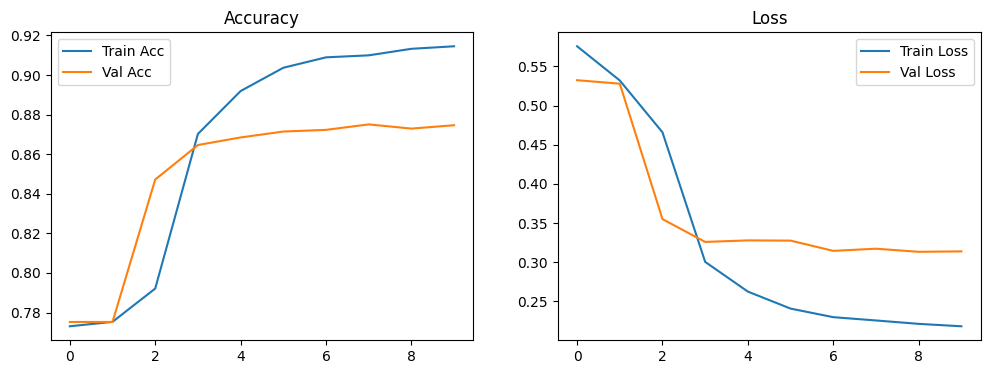

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Final Evaluation on Test Set:
Accuracy : 0.8748
Precision: 0.9046
Recall   : 0.9374
F1 Score : 0.9207
AUC      : 0.9134
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1056
           1       0.90      0.94      0.92      3642

    accuracy                           0.87      4698
   macro avg       0.83      0.80      0.81      4698
weighted avg       0.87      0.87      0.87      4698

AUC Score: 0.7982439718436424


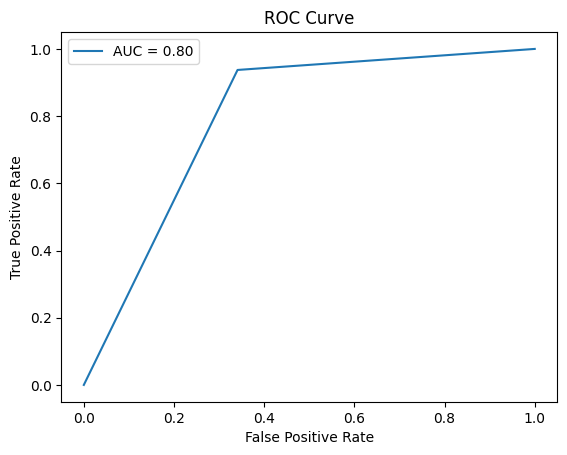


Information:
 1 : Recommended
 0 : Not Recommended

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Sample Predictions:
1. Text: comfortable happening pants ever owned extremely flattering slimming waist size bought fit perfectly...
   True: 1, Pred: 1, Prob: 0.9990

2. Text: love pants care laundry dye transferred another pair pilcro chinos little lighter color frustrating ...
   True: 0, Pred: 1, Prob: 0.8249

3. Text: cozy beautiful everything dreamy sleep pants great make bedtime feel little pampered
   True: 1, Pred: 1, Prob: 0.9879

4. Text: ditto first reviewer said unfortunately looking forward receiving dress one received one photos grap...
   True:

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluation Metrics
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


print(classification_report(y_test, y_pred_bin))
print("AUC Score:", roc_auc_score(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred):.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


def get_sample_predictions(n_samples=10):
    samples = []

    # Create reverse vocabulary for visualization
    idx_to_word = {idx: word for word, idx in vocabulary.items()}

    # Get some random samples from test set
    indices = np.random.choice(len(X_test), n_samples, replace=False)

    for i in indices:
        # Get sequence and convert to text
        seq = X_test[i]
        words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
        text = ' '.join(words)

        # Get true and predicted values
        true_val = y_test[i]
        prob_val = model.predict(np.expand_dims(seq, axis=0))[0][0]
        pred_val = 1 if prob_val >= 0.5 else 0

        samples.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true': true_val,
            'pred': pred_val,
            'prob': prob_val
        })

    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions()
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# Model dan Metrik Evaluasi dalam Deep Learning untuk Teks

## 1. Recurrent Neural Network (RNN)

RNN adalah jaringan syaraf yang mempertahankan konteks waktu melalui hidden state. Persamaan dasarnya adalah:

$$
h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

$$
y_t = W_{hy} h_t + b_y
$$

Keterangan:
- \( x_t \): input pada waktu \( t \)
- \( h_t \): hidden state pada waktu \( t \)
- \( y_t \): output pada waktu \( t \)
- \( W_{xh}, W_{hh}, W_{hy} \): matriks bobot
- \( b_h, b_y \): bias

---

## 2. Long Short-Term Memory (LSTM)

LSTM mengatasi masalah vanishing gradient dengan mekanisme gerbang (gates). Persamaan lengkap LSTM adalah:

$$
f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f) \quad \text{(forget gate)}
$$

$$
i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i) \quad \text{(input gate)}
$$

$$
\tilde{c}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c) \quad \text{(candidate cell)}
$$

$$
c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \quad \text{(cell state)}
$$

$$
o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o) \quad \text{(output gate)}
$$

$$
h_t = o_t \odot \tanh(c_t) \quad \text{(hidden state)}
$$

---

## 3. Gated Recurrent Unit (GRU)

GRU adalah varian dari LSTM yang lebih sederhana:

$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z) \quad \text{(update gate)}
$$

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r) \quad \text{(reset gate)}
$$

$$
\tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
$$

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

---

## 4. Metrik Evaluasi

### 4.1 Accuracy

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

### 4.2 Precision

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### 4.3 Recall

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### 4.4 F1 Score

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### 4.5 Area Under Curve (AUC Score)

AUC Score adalah luas di bawah kurva ROC (Receiver Operating Characteristic), didefinisikan sebagai:

$$
\text{AUC} = \int_{0}^{1} TPR(FPR^{-1}(x)) \, dx
$$




# Perbandingan Evaluasi Model: RNN vs GRU vs LSTM

##  1. Ringkasan Hasil Evaluasi

| Metric       | RNN     | GRU     | LSTM    |
|--------------|---------|---------|---------|
| Accuracy     | 0.8748  | 0.8748  | 0.8629  |
| Precision    | 0.9046  | 0.9046  | 0.9065  |
| Recall       | 0.9374  | 0.9374  | 0.9179  |
| F1 Score     | 0.9207  | 0.9207  | 0.9121  |
| AUC Score    | 0.9134  | 0.9134  | 0.9078  |

---

##  2. Penjelasan Metrik

- **Accuracy**: Persentase prediksi yang benar dibanding total sampel.
- **Precision**: Proporsi prediksi positif yang benar-benar positif (`TP / (TP + FP)`).
- **Recall**: Kemampuan model dalam menemukan semua data positif (`TP / (TP + FN)`).
- **F1 Score**: Rata-rata harmonis antara precision dan recall.
- **AUC (Area Under Curve)**: Kemampuan model membedakan antara kelas positif dan negatif.

---

##  3. Klasifikasi per Kelas

| Class | Model | Precision | Recall | F1 Score |
|-------|-------|-----------|--------|----------|
| **0** (Negatif) | RNN   | 0.75      | 0.66   | 0.70     |
|                 | GRU   | 0.75      | 0.66   | 0.70     |
|                 | LSTM  | 0.71      | 0.68   | 0.69     |
| **1** (Positif) | RNN   | 0.90      | 0.94   | 0.92     |
|                 | GRU   | 0.90      | 0.94   | 0.92     |
|                 | LSTM  | 0.91      | 0.92   | 0.91     |


---

##  4. Analisis Sample Predictions

### GRU & RNN Sample Prediction Errors:

- **Sample 2**:  
  - `True: 0`, `Pred: 1`, `Prob: 0.8249`  
  - Komentar: False Positive — review negatif diprediksi positif.

- **Sample 4**:  
  - `True: 0`, `Pred: 1`, `Prob: 0.5107`  
  - Komentar: Borderline case — model tidak yakin.

### LSTM Sample Prediction Errors:

- **Sample 2 & 3**:  
  - `True: 0`, `Pred: 1`, `Prob: 0.7073 / 0.8680`  
  - Komentar: Model kurang akurat untuk review singkat atau ambigu.

- **Sample 10**:  
  - `True: 1`, `Pred: 0`, `Prob: 0.1819`  
  - Komentar: False Negative — review positif dikira negatif.

---



